In [203]:
RFTrackPath = '/home/pkruyt/cernbox/rf-track-2.0'
import sys
import numpy as np
sys.path.append(RFTrackPath)

import RF_Track as RFT




In [204]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
magnetic_field = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T

print('sec_per_turn',s_per_turn)

alpha_x=0
alpha_y=0
Q_x=5.44
Q_y=5.42
DQx=0
DQy=0
momentum_compaction=0


beta_x=10 
beta_y=4

#disp_x=0.12
disp_x=0

arc=xt.LinearTransferMatrix(Q_x=Q_x, Q_y=Q_y,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=disp_x,disp_x_1=disp_x,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0)

sec_per_turn 1.9951813726709976e-06


In [205]:
# twiss = np.array([length,beta_x, alpha_x, Q_x, beta_y, alpha_y, Q_y])
# transfer_line = RFT.TransferLine(twiss)

#% Crate one matching transfer matrix for the rest of the ring
twiss = np.zeros((2, 11))
twiss[0,:] = [ 0, beta_x, -alpha_x, 0,  beta_y, -alpha_y, 0 , 0, 0, 0, 0]; #% cooler end
twiss[1,:] = [ length, beta_x,  alpha_x, Q_x, beta_y,  alpha_y, Q_y, 0, 0, 0, 0]; #% cooler start

transfer_line = RFT.TransferLine(twiss, DQx, DQy, 0, p0c*1e-6)


In [206]:
num_particles=2
#old
emittance=35*1e-6 #inital emittance
emittance=5*1e-6 #inital emittance

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 5e-4

delta = np.random.normal(loc=0.0, scale=sigma_p,  size=num_particles)
x =     np.random.normal(loc=0.0, scale=sigma_x,  size=num_particles)+disp_x*delta
px =    np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y =     np.random.normal(loc=0.0, scale=sigma_y,  size=num_particles)
py =    np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

t= np.random.normal(loc=0.0, scale=0.0, size=num_particles)
p = delta*p0c+p0c

particles = xp.Particles(
        
        mass0=mass0,
        q0=1,
        p0c=p0c,
        x=x,
        px=px,
        y=0,
        py=0,
        delta=0,
        zeta=0)


###########################################################################################################
from Xsuite_to_RF import XSUITE_TO_RF_converter
from RF_to_Xsuite import RF_TO_XSUITE_converter

beam=XSUITE_TO_RF_converter(particles)

#B = RFT.Bunch6d(mass0, num_particles, 1, [x,px,y,py,t, p] )






In [207]:
num_turns = int(1e2)

# Create empty lists to store RF track data
x_rf_list = []
px_rf_list = []

# Create empty lists to store data
x_xs_list = []
px_xs_list = []

# Perform the loop
for i in tqdm(range(num_turns)):

    
    x_rf = beam.get_phase_space("%x") * 1e-3
    px_rf = beam.get_phase_space("%xp") * 1e-3
    x_rf_list.append(x_rf.flatten()[1::])
    px_rf_list.append(px_rf.flatten()[1::])
    transfer_line.track(beam)

# Perform the loop
for i in tqdm(range(num_turns)):
    
    
    x_xs = particles.x.copy()
    px_xs = particles.px.copy()
    x_xs_list.append(x_xs)
    px_xs_list.append(px_xs)
    arc.track(particles)



100%|██████████| 100/100 [00:00<00:00, 10239.00it/s]


In [208]:
print(x_rf_list[1])
print(x_xs_list[1])

[0.00336679 0.00508211]
[0.00336679 0.00508211]


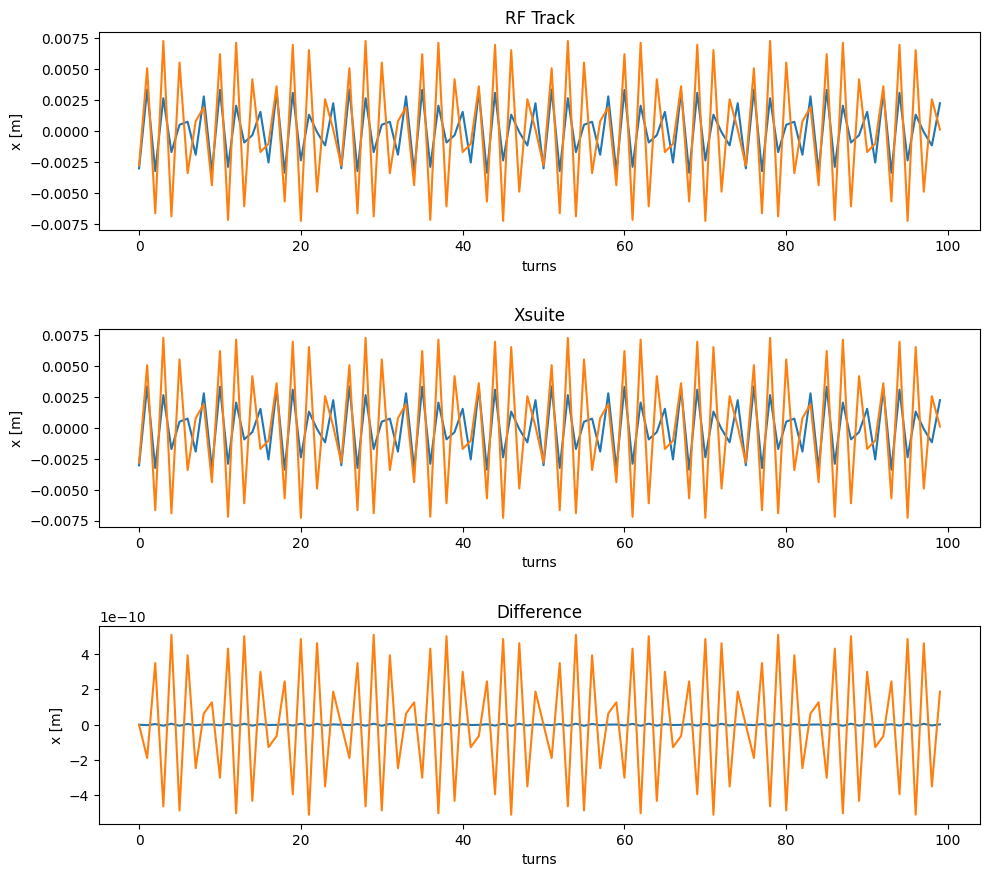

In [209]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot RF Track
ax1.plot(x_rf_list)
ax1.set_title('RF Track')
ax1.set_xlabel('turns')
ax1.set_ylabel('x [m]')

# Plot Xsuite
ax2.plot(x_xs_list)
ax2.set_title('Xsuite')
ax2.set_xlabel('turns')
ax2.set_ylabel('x [m]')

# Calculate the difference array
xs_array = np.array(x_xs_list)
rf_array = np.array(x_rf_list)
difference_array = xs_array - rf_array

# Plot the difference array
ax3.plot(difference_array)
ax3.set_title('Difference')
ax3.set_xlabel('turns')
ax3.set_ylabel('x [m]')

# Adjust spacing between subplots
plt.tight_layout()

# Rearrange subplots
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.85)

# Display the figure
plt.show()


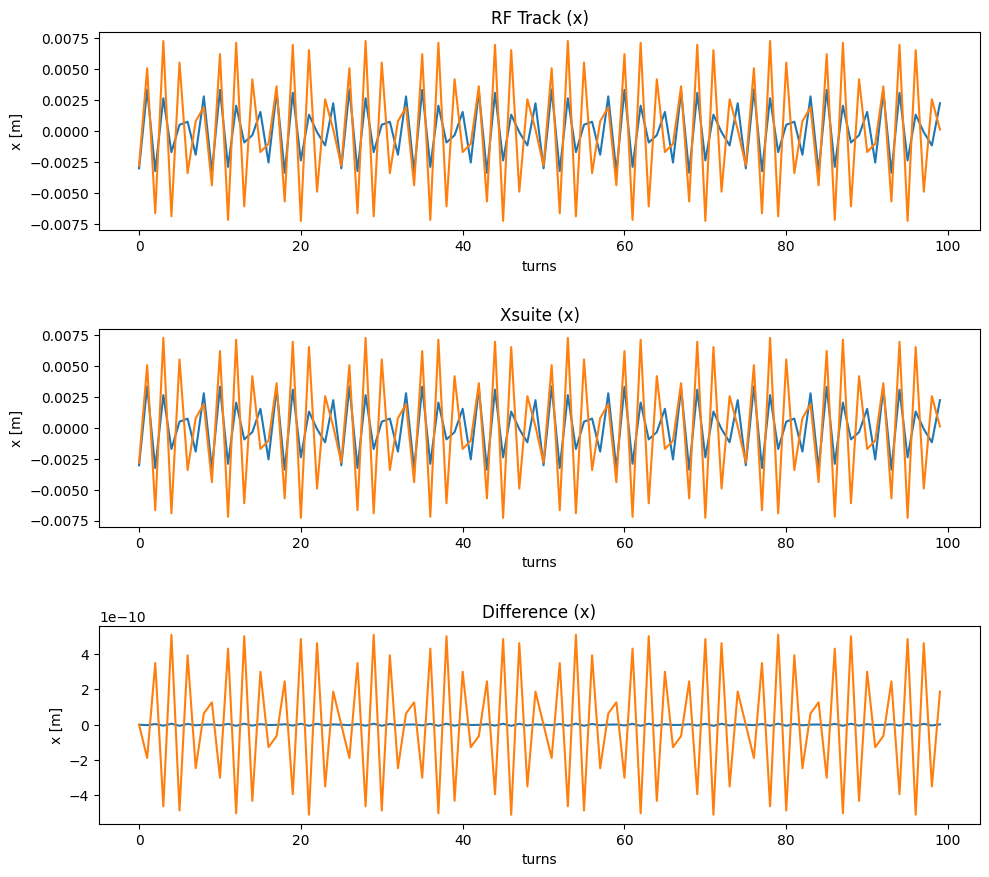

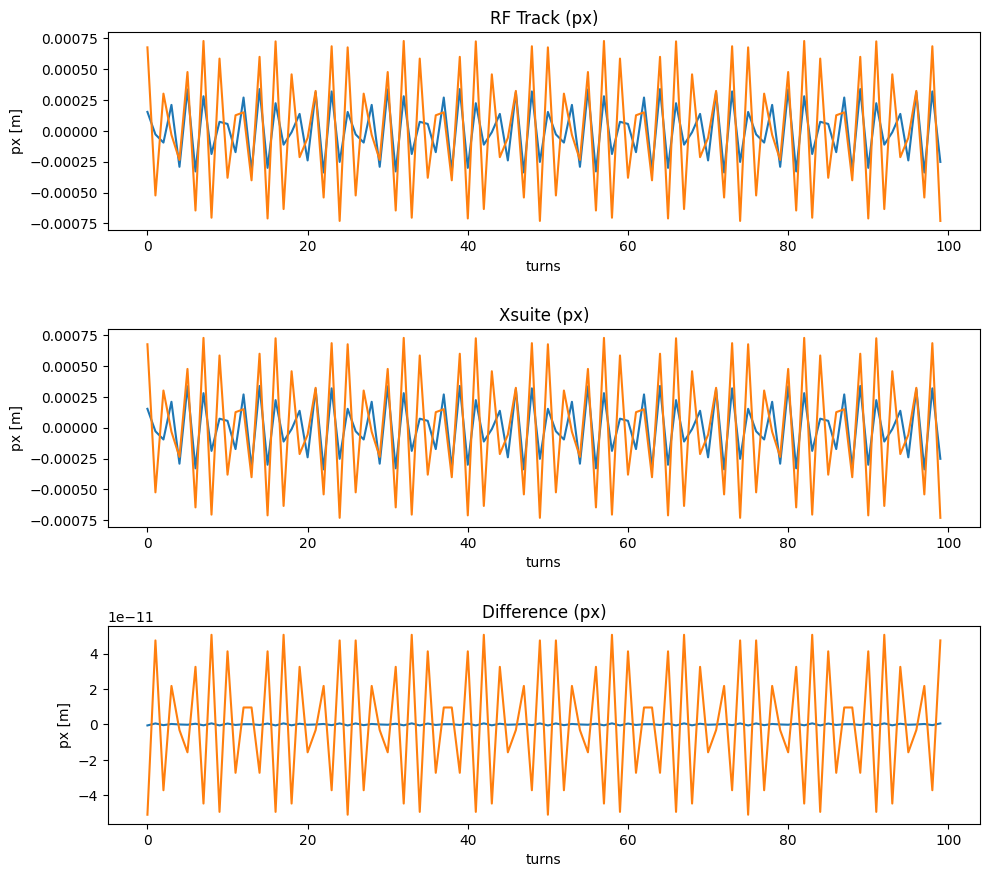

In [210]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots for x
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# Plot RF Track for x
ax1.plot(x_rf_list)
ax1.set_title('RF Track (x)')
ax1.set_xlabel('turns')
ax1.set_ylabel('x [m]')

# Plot Xsuite for x
ax2.plot(x_xs_list)
ax2.set_title('Xsuite (x)')
ax2.set_xlabel('turns')
ax2.set_ylabel('x [m]')

# Calculate the difference array for x
xs_array = np.array(x_xs_list)
rf_array = np.array(x_rf_list)
difference_array = xs_array - rf_array

# Plot the difference array for x
ax3.plot(difference_array)
ax3.set_title('Difference (x)')
ax3.set_xlabel('turns')
ax3.set_ylabel('x [m]')

# Adjust spacing between subplots for x
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(top=0.85)

# Create subplots for px
fig2, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(10, 10))

# Plot RF Track for px
ax4.plot(px_rf_list)
ax4.set_title('RF Track (px)')
ax4.set_xlabel('turns')
ax4.set_ylabel('px [m]')

# Plot Xsuite for px
ax5.plot(px_xs_list)
ax5.set_title('Xsuite (px)')
ax5.set_xlabel('turns')
ax5.set_ylabel('px [m]')

# Calculate the difference array for px
px_xs_array = np.array(px_xs_list)
px_rf_array = np.array(px_rf_list)
px_difference_array = px_xs_array - px_rf_array

# Plot the difference array for px
ax6.plot(px_difference_array)
ax6.set_title('Difference (px)')
ax6.set_xlabel('turns')
ax6.set_ylabel('px [m]')

# Adjust spacing between subplots for px
plt.tight_layout()
fig2.subplots_adjust(hspace=0.5)
fig2.subplots_adjust(top=0.85)

# Display the figures
plt.show()
